📊 Hiển thị 5 dòng đầu của dữ liệu:
  Mã khách hàng               Danh mục             Mặt hàng  Số lượng  \
0     CUST_0159              Groceries                 Milk         1   
1     CUST_0017      Friend Activities  Dinner with Friends         2   
2     CUST_0094  Housing and Utilities           Water Bill         1   
3     CUST_0162                Fitness           Yoga Class         5   
4     CUST_0129                  Gifts              Flowers         3   

   Giá mỗi đơn vị  Tổng chi tiêu Phương thức thanh toán    Địa điểm  \
0            1.28           1.28             Debit Card  Mobile App   
1           74.69         149.39             Debit Card    In-store   
2           76.06          76.06         Digital Wallet  Mobile App   
3           11.24          56.18                   Cash    In-store   
4           43.71         131.12             Debit Card    In-store   

  Ngày giao dịch  
0     2024-11-13  
1     2023-05-04  
2     2023-12-16  
3     2024-01-28  
4   

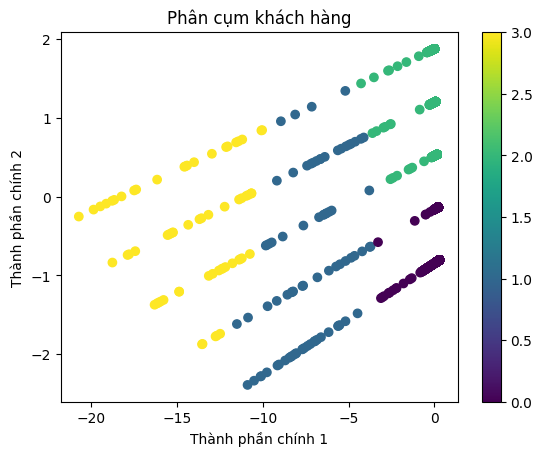

03:58:56 - cmdstanpy - INFO - Chain [1] start processing



📌 Top 5 danh mục phổ biến nhất:
    Category  count
0  Groceries    799
1    Fitness    799
2       Food    794
3      Gifts    789
4   Shopping    775
🔍 Danh mục phổ biến nhất: Groceries

📊 Dự đoán xu hướng chi tiêu cho danh mục: Groceries


03:58:57 - cmdstanpy - INFO - Chain [1] done processing


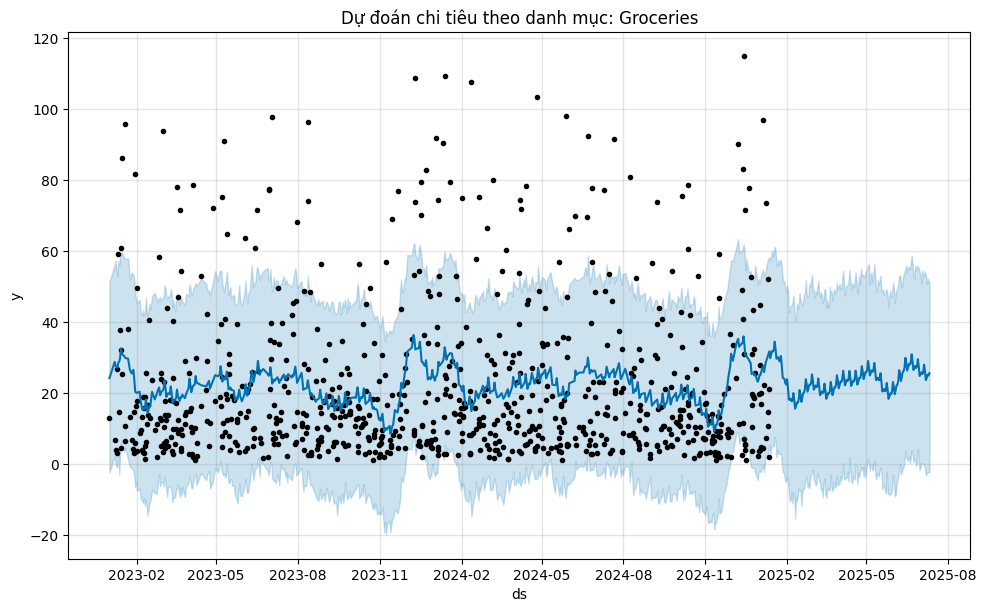

03:58:57 - cmdstanpy - INFO - Chain [1] start processing



📊 Dự đoán xu hướng chi tiêu cho danh mục: Fitness


03:58:57 - cmdstanpy - INFO - Chain [1] done processing


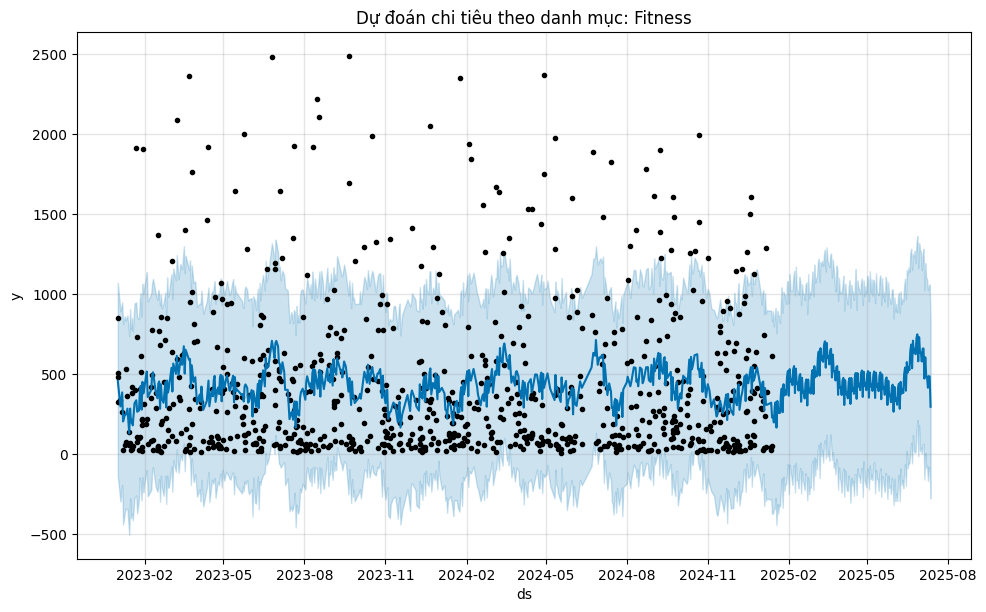

03:58:57 - cmdstanpy - INFO - Chain [1] start processing



📊 Dự đoán xu hướng chi tiêu cho danh mục: Food


03:58:58 - cmdstanpy - INFO - Chain [1] done processing


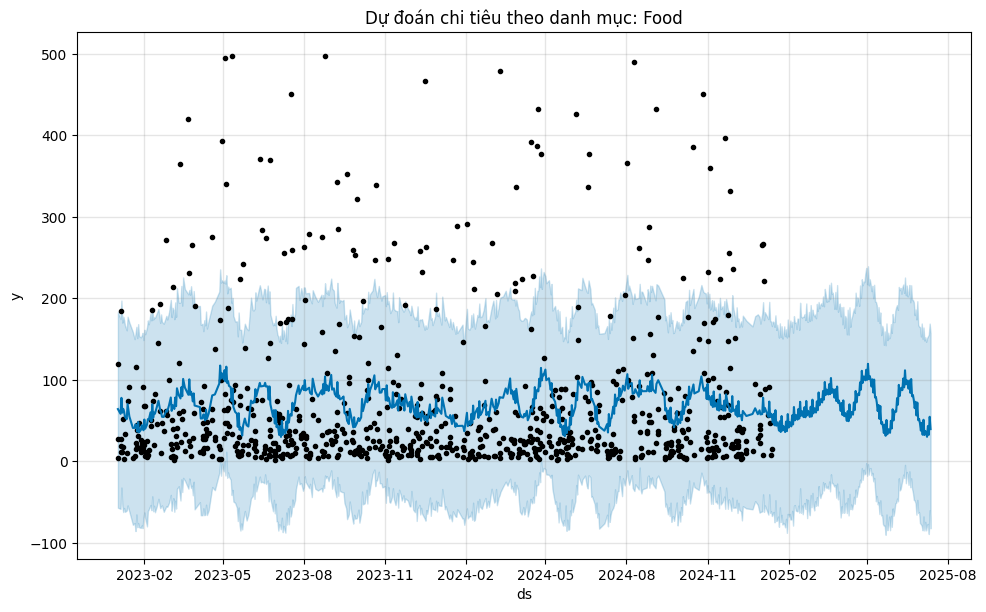

03:58:58 - cmdstanpy - INFO - Chain [1] start processing



📊 Dự đoán xu hướng chi tiêu cho danh mục: Gifts


03:58:58 - cmdstanpy - INFO - Chain [1] done processing


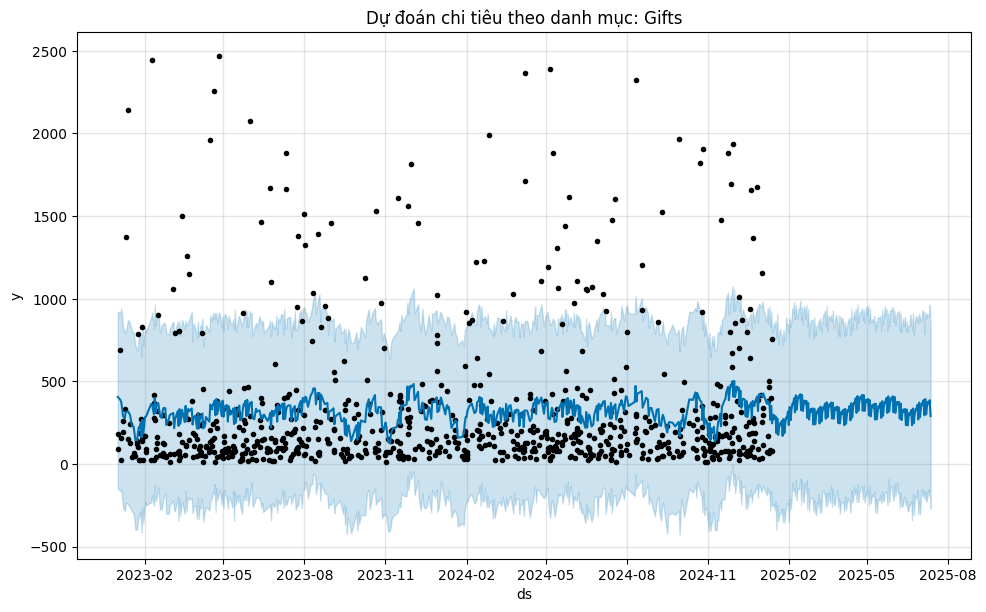

03:58:58 - cmdstanpy - INFO - Chain [1] start processing



📊 Dự đoán xu hướng chi tiêu cho danh mục: Shopping


03:58:59 - cmdstanpy - INFO - Chain [1] done processing


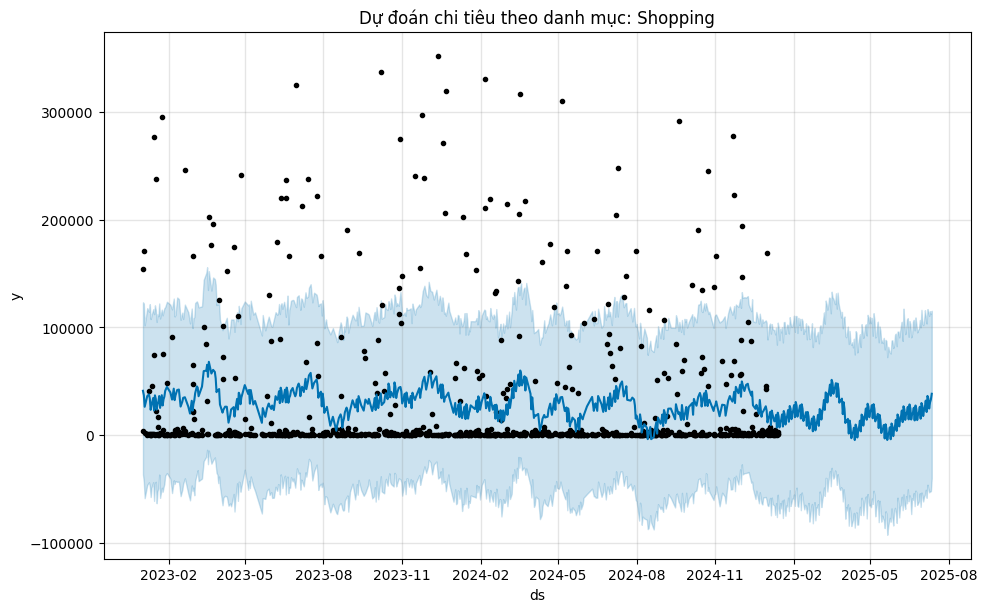

💰 Danh sách khách hàng chi tiêu nhiều nhất:
  Customer ID  Total Spending
0   CUST_0033       676346.70
1   CUST_0163       589432.75
2   CUST_0040       515134.58
3   CUST_0034       504948.72
4   CUST_0039       498365.86

🏆 Top khách hàng chi tiêu nhiều nhất: ['CUST_0033', 'CUST_0163', 'CUST_0040', 'CUST_0034', 'CUST_0039']
📢 Gợi ý sản phẩm thông minh cho khách hàng CUST_0033: ['Shopping', 'Food', 'Gifts']
📢 Gợi ý sản phẩm thông minh cho khách hàng CUST_0163: ['Groceries', 'Fitness', 'Shopping']
📢 Gợi ý sản phẩm thông minh cho khách hàng CUST_0040: ['Groceries', 'Shopping', 'Hobbies']
📢 Gợi ý sản phẩm thông minh cho khách hàng CUST_0034: ['Shopping', 'Medical/Dental', 'Groceries']
📢 Gợi ý sản phẩm thông minh cho khách hàng CUST_0039: ['Shopping', 'Friend Activities', 'Fitness']


In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from prophet import Prophet

# Cấu hình môi trường Spark
os.environ["HADOOP_HOME"] = "/tmp"
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-17"
os.environ["SPARK_HOME"] = "/tmp"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.driver.extraJavaOptions="-Dderby.system.home=/tmp/derby" pyspark-shell'

class CustomerSpendingPrediction:
    def __init__(self):
        self.spark = SparkSession.builder.appName("CustomerSpending").master("local[*]").getOrCreate()
        self.data = None
        self.model = None
        self.feature_columns = ["Quantity", "Price Per Unit", "Total Spent"]
        self.processed_data = None

    def load_data(self, path):
        """Load dữ liệu từ file CSV"""
        self.data = self.spark.read.csv(path, header=True, inferSchema=True)
        if self.data.count() == 0:
            raise ValueError("Dữ liệu rỗng hoặc không tồn tại!")

    def preprocess_data(self):
        """Tiền xử lý dữ liệu"""
        available_columns = self.data.columns
        self.feature_columns = [col for col in self.feature_columns if col in available_columns]
        assembler = VectorAssembler(inputCols=self.feature_columns, outputCol="features")
        data = assembler.transform(self.data)
        scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
        self.processed_data = scaler.fit(data).transform(data)

    def train_kmeans(self, k=3):
        """Huấn luyện mô hình KMeans"""
        kmeans = KMeans(k=k, featuresCol="scaledFeatures", predictionCol="Cluster")
        self.model = kmeans.fit(self.processed_data)
        self.processed_data = self.model.transform(self.processed_data)

    def display_data(self):
        """Hiển thị 5 dòng đầu của dữ liệu"""
        column_mapping = {
            "Customer ID": "Mã khách hàng",
            "Category": "Danh mục",
            "Item": "Mặt hàng",
            "Quantity": "Số lượng",
            "Price Per Unit": "Giá mỗi đơn vị",
            "Total Spent": "Tổng chi tiêu",
            "Payment Method": "Phương thức thanh toán",
            "Location": "Địa điểm",
            "Transaction Date": "Ngày giao dịch"
        }
        df = self.data.limit(5).toPandas()
        df.rename(columns=column_mapping, inplace=True)
        print("📊 Hiển thị 5 dòng đầu của dữ liệu:")
        print(df)

    def get_top_categories(self, n=5):
        """Lấy N danh mục xuất hiện nhiều nhất"""
        top_categories = (
            self.data.groupBy("Category")
            .agg(count("*").alias("count"))
            .orderBy(col("count").desc())
            .limit(n)
        ).toPandas()
        
        print("\n📌 Top 5 danh mục phổ biến nhất:")
        print(top_categories)

        return top_categories["Category"].tolist()

    def apply_pca(self, k=2):
        """Giảm chiều dữ liệu bằng PCA"""
        pca = PCA(k=k, inputCol="scaledFeatures", outputCol="pcaFeatures")
        pca_model = pca.fit(self.processed_data)
        pca_result = pca_model.transform(self.processed_data)
        pdf = pca_result.select("pcaFeatures", "Cluster").toPandas()
        pdf[["PC1", "PC2"]] = pdf["pcaFeatures"].apply(lambda x: pd.Series(x.toArray()))
        return pdf

    def plot_clusters(self):
        """Vẽ biểu đồ phân cụm"""
        pdf = self.apply_pca()
        plt.scatter(pdf["PC1"], pdf["PC2"], c=pdf["Cluster"], cmap="viridis")
        plt.xlabel("Thành phần chính 1")
        plt.ylabel("Thành phần chính 2")
        plt.title("Phân cụm khách hàng")
        plt.colorbar()
        plt.show()

    def forecast_spending(self, category):
        """Dự báo xu hướng chi tiêu cho một danh mục"""
        pdf = self.data.filter(self.data["Category"] == category).select("Transaction Date", "Total Spent").toPandas()
        pdf.rename(columns={"Transaction Date": "ds", "Total Spent": "y"}, inplace=True)
        
        if pdf.empty:
            print(f"⚠️ Không có dữ liệu cho danh mục '{category}' để dự đoán.")
            return
        
        model = Prophet()
        model.fit(pdf)
        future = model.make_future_dataframe(periods=180)
        forecast = model.predict(future)
        
        model.plot(forecast)
        plt.title(f"Dự đoán chi tiêu theo danh mục: {category}")
        plt.show()
    def find_top_spenders(self, top_n=5):
        """Tìm danh sách top khách hàng chi tiêu nhiều nhất"""
        top_spenders = (
            self.data.groupBy("Customer ID")
            .agg(sum("Total Spent").alias("Total Spending"))
            .orderBy(col("Total Spending").desc())
            .limit(top_n)
        ).toPandas()

        if top_spenders.empty:
            print("⚠️ Không có dữ liệu khách hàng!")
            return []
        
        print("💰 Danh sách khách hàng chi tiêu nhiều nhất:")
        print(top_spenders)
        return top_spenders["Customer ID"].tolist()

    def recommend_products_smart(self, customer_id):
        """Gợi ý sản phẩm thông minh dựa trên lịch sử mua hàng và xu hướng chung"""
        customer_purchases = (
            self.data.filter(self.data["Customer ID"] == customer_id)
            .groupBy("Category")
            .agg(count("Item").alias("Purchase Count"))
            .orderBy(col("Purchase Count").desc())
            .limit(3)
        ).toPandas()

        if customer_purchases.empty:
            print(f"⚠️ Không tìm thấy dữ liệu mua hàng cho khách hàng {customer_id}")
            return

        recommended_categories = customer_purchases["Category"].tolist()
        print(f"📢 Gợi ý sản phẩm thông minh cho khách hàng {customer_id}: {recommended_categories}")

if __name__ == "__main__":
    predictor = CustomerSpendingPrediction()
    predictor.load_data("spending_patterns_detailed.csv")
    predictor.display_data()
    predictor.preprocess_data()
    predictor.train_kmeans(k=4)
    predictor.plot_clusters()

   
    # Tìm danh mục phổ biến và dự báo chi tiêu
    top_categories = predictor.get_top_categories(n=5)
    if top_categories:
        print(f"🔍 Danh mục phổ biến nhất: {top_categories[0]}")
        for category in top_categories:
            print(f"\n📊 Dự đoán xu hướng chi tiêu cho danh mục: {category}")
            predictor.forecast_spending(category=category)
     # Tìm khách hàng chi tiêu nhiều nhất
    top_spenders = predictor.find_top_spenders(top_n=5)
    if top_spenders:
        print(f"\n🏆 Top khách hàng chi tiêu nhiều nhất: {top_spenders}")
        
        # Gợi ý sản phẩm cho từng khách hàng trong danh sách top
        for customer_id in top_spenders:
            predictor.recommend_products_smart(customer_id)
